# Scripting en Waveforms

Implementaremos una señal en el scripting de Waveforms para generar la señal

In [8]:
import numpy as np
from pydwf import DwfLibrary, DwfWindow

In [4]:
dwf = DwfLibrary()

print("DWF library version:", dwf.getVersion())

DWF library version: 3.23.4


In [5]:
device_count = dwf.deviceEnum.enumerateDevices()

print("Number of Digilent Waveforms devices found:", device_count)

Number of Digilent Waveforms devices found: 1


In [6]:
# Open the first available Digilent Waveforms device, and close it immediately.
device = dwf.deviceControl.open(-1)
device.close()

In [9]:
# Make an 11-element Hamming window.
(hamming_window, noise_equivalent_bandwidth) = dwf.spectrum.window(11, DwfWindow.Hamming)

## Initialize the Wavegenerator

Use the waveform generator to generate different signals.

## Initialize the scope

In [10]:
from pydwf import DwfLibrary
from pydwf.utilities import openDwfDevice

dwf = DwfLibrary()

with openDwfDevice(dwf) as device:

    # Get a reference to the device's AnalogIn instrument.
    analogIn = device.analogIn

    # Use the AnalogIn instrument.
    analogIn.reset()

Analog Discovery conectado.
Señal enviada a la salida analógica.
Señal capturada con el osciloscopio.


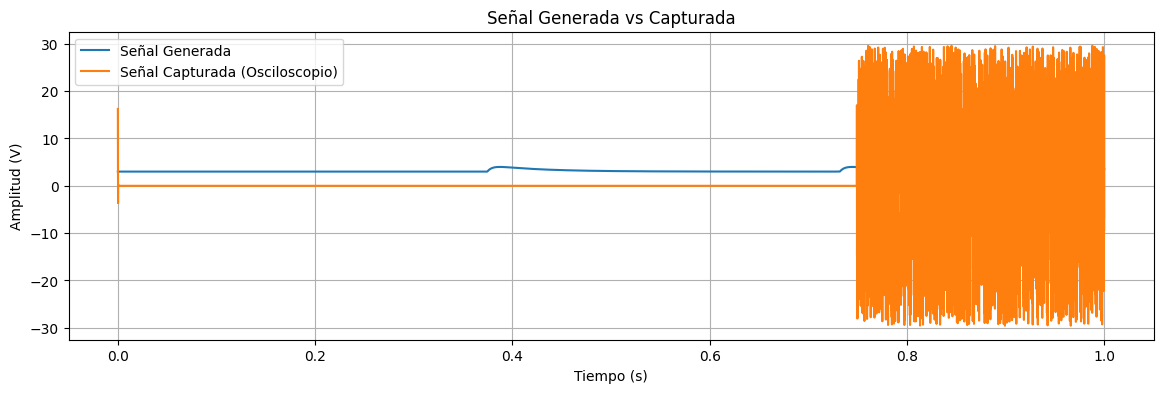

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from pydwf import DwfLibrary
from pydwf.core.api.analog_out import DwfAnalogOutNode, DwfAnalogOutFunction
from pydwf.core.api.analog_in import DwfAcquisitionMode, DwfTriggerSource, DwfTriggerSlope
import time

# --- Configuración de parámetros ---
fs = 1e4  # Frecuencia de muestreo: 1 MHz
duration = 1  # Duración total de la señal (en segundos)
num_points = int(fs * duration)

# Modelo de la señal: una suma de pulsos
def radiation_event(t, t_0, A, tau_D, tau_R):
    return A * (np.exp(-(t - t_0) / tau_D) - np.exp(-(t - t_0) / tau_R))

# Generar la señal
t = np.linspace(0, duration, num_points)
signal = np.zeros_like(t)
num_pulses = 3  # Número de pulsos
np.random.seed(42)
pulse_times = np.random.uniform(0, duration, num_pulses)

A, tau_D, tau_R = 4, 0.05, 0.005  # Parámetros del pulso
for t_0 in pulse_times:
    pulse = radiation_event(t, t_0, A, tau_D, tau_R)
    pulse[t < t_0] = 0  # Solo después de t_0
    signal += pulse

# Normalizar la señal
signal = signal / np.max(np.abs(signal)) * 1.0  # Escalar a rango -2V a +2V

# --- Configuración del Analog Discovery ---
dwf = DwfLibrary()  # Inicializar pydwf
with openDwfDevice(dwf) as device:  # Abre el dispositivo conectado
    print("Analog Discovery conectado.")

    # --- Configurar el osciloscopio (Analog Input) ---
    analog_in = device.analogIn
    analog_in.channelRangeSet(0, 10.0)  # Rango de voltaje +-5V
    analog_in.acquisitionModeSet(DwfAcquisitionMode.Single) # analog_in.ACQMODE.SINGLE
    analog_in.frequencySet(10*fs)
    analog_in.bufferSizeSet(len(signal))

    # Configurar el Trigger para sincronización
    analog_in.triggerSourceSet(DwfTriggerSource.AnalogIn)  # Configura trigger en el canal 1
    analog_in.triggerConditionSet(DwfTriggerSlope.Rise)  # Condición de trigger: umbral ascendente
    analog_in.triggerLevelSet(0.5)  # Nivel de trigger en 0.5V (ajústalo según la señal)



    # --- Configurar la salida analógica (Waveform Generator) ---
    analog_out = device.analogOut
    analog_out.nodeEnableSet(0, DwfAnalogOutNode.Carrier, 1) #  analog_out.NODE.CARRIER
    analog_out.nodeFunctionSet(0, DwfAnalogOutNode.Carrier, DwfAnalogOutFunction.Custom) #  analog_out.NODE.CARRIER, analog_out.FUNC.CUSTOM
    analog_out.amplitudeSet(0, 4)
    analog_out.nodeDataSet(0, DwfAnalogOutNode.Carrier, signal)  # Cargar la señal
    analog_out.frequencySet(0, fs / len(signal))  # Configurar frecuencia de muestreo
    # analog_out.frequencySet(0, 20e3)  # Configurar frecuencia de muestreo
    analog_out.configure(0, 1)
    print("Señal enviada a la salida analógica.")

    

    # Iniciar la captura
    analog_in.configure(False, True)  # Preparar para adquisición
    while not analog_in.status(True):  # Esperar adquisición completa
        pass

    # Iniciar captura
    analog_in.configure(0, 1)
    analog_in.status(1)  # Esperar adquisición

    # Leer datos
    captured_data = analog_in.statusData(0, len(signal))
    print("Señal capturada con el osciloscopio.")

    # Detener la salida
    # analog_out.configure(0, 0)
    # print("Señal detenida.")

    time.sleep(1)

    

# --- Visualizar la señal capturada ---
plt.figure(figsize=(14, 4))
plt.plot(t, signal+3, label="Señal Generada")
plt.plot(t, captured_data, label="Señal Capturada (Osciloscopio)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (V)")
plt.title("Señal Generada vs Capturada")
plt.legend()
plt.grid()
plt.show()


Analog Discovery conectado.
Enable: True
Range: 59.24044588437883
AdqMode: DwfAcquisitionMode.Record
Frequency: 50000.0
Buffer: 10000
TrgSource: DwfTriggerSource.DetectorAnalogIn
TrgChann: 0
TrgCond: DwfTriggerSlope.Rise
TrgLevel: 2.4992837220409734
Esperando señal...
Señal capturada correctamente.


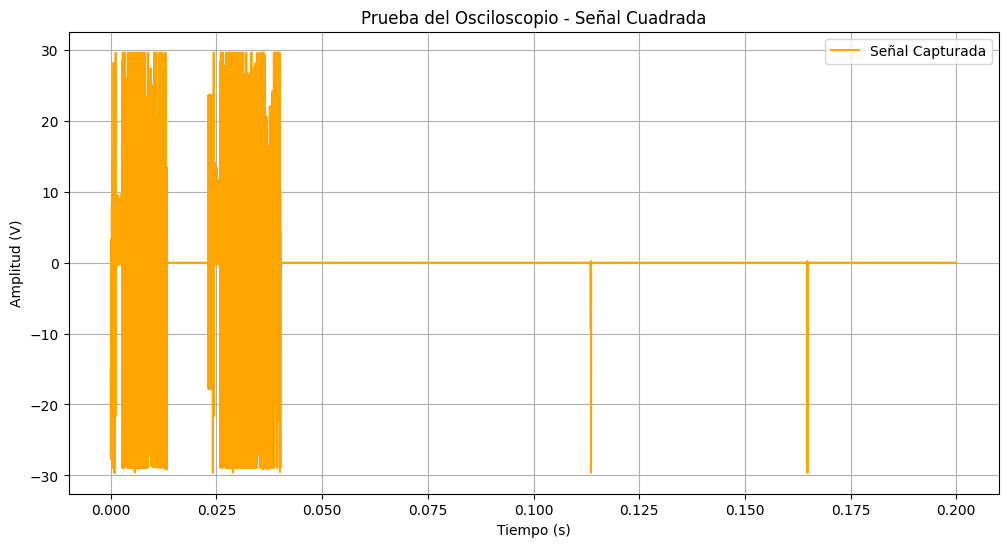

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pydwf import DwfLibrary
from pydwf.core.api.analog_in import DwfAcquisitionMode, DwfTriggerSource, DwfTriggerSlope
import time

# --- Parámetros de prueba ---
fs = 50e3  # Frecuencia de muestreo (50 kHz)
buffer_size = 10000  # Tamaño del buffer (número de puntos)
signal_frequency = 1e3  # Frecuencia de la señal esperada (1 kHz)
trigger_level = 2.5  # Nivel de trigger (mitad de la amplitud de 5V)
ch = 0

# --- Configuración del Analog Discovery ---
dwf = DwfLibrary()  # Inicializar la librería pydwf

with openDwfDevice(dwf) as device:  # Abrir el dispositivo
    print("Analog Discovery conectado.")

    # --- Configurar el osciloscopio (Analog Input) ---
    analog_in = device.analogIn
    analog_in.reset()  # Resetear configuración
    analog_in.channelEnableSet(ch, True)  # Habilitar el canal 1
    print("Enable:",analog_in.channelEnableGet(0))
    analog_in.channelRangeSet(ch, 10.0)  # Rango de voltaje ±10V
    print("Range:",analog_in.channelRangeGet(0))
    analog_in.acquisitionModeSet(DwfAcquisitionMode.Record)  # Adquisición única
    print("AdqMode:",analog_in.acquisitionModeGet())
    analog_in.frequencySet(fs)  # Frecuencia de muestreo
    print("Frequency:",analog_in.frequencyGet())
    analog_in.bufferSizeSet(buffer_size)  # Tamaño del buffer
    print("Buffer:",analog_in.bufferSizeGet())

    # Configurar filtro digital
    # analog_in.channelFilterSet(0, 2)  # Filtro promedio

    # Configurar Trigger
    analog_in.triggerSourceSet(DwfTriggerSource.DetectorAnalogIn)  # Trigger en el canal 1
    print("TrgSource:",analog_in.triggerSourceGet())
    analog_in.triggerChannelSet(ch)  # Trigger en el canal 1
    print("TrgChann:",analog_in.triggerChannelGet())
    analog_in.triggerConditionSet(DwfTriggerSlope.Rise)  # Flanco ascendente
    print("TrgCond:",analog_in.triggerConditionGet())
    analog_in.triggerLevelSet(trigger_level)  # Nivel del trigger en 2.5V
    print("TrgLevel:",analog_in.triggerLevelGet())

    # --- Captura de la señal ---
    analog_in.configure(ch, True)  # Configurar y armar el osciloscopio
    print("Esperando señal...")
    while not analog_in.status(True):  # Esperar la adquisición
        pass

    time.sleep(0.5)  # Pequeña espera para estabilidad

    # Leer los datos capturados
    captured_data = analog_in.statusData(ch, buffer_size)
    print("Señal capturada correctamente.")

# --- Generar vector de tiempo ---
tiempo = np.linspace(0, buffer_size / fs, buffer_size)

# --- Visualización de la señal capturada ---
plt.figure(figsize=(12, 6))
plt.plot(tiempo, captured_data, label="Señal Capturada", color='orange')
plt.title("Prueba del Osciloscopio - Señal Cuadrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (V)")
plt.grid()
plt.legend()
plt.show()


Esperando adquisición...
Nota: Se descartan 4807 muestras excedentes.


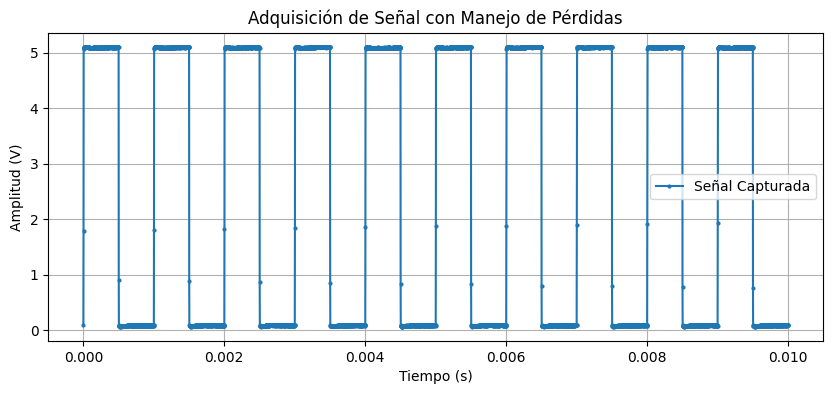

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pydwf import DwfLibrary, DwfAcquisitionMode, DwfTriggerSource, DwfAnalogInTriggerType, DwfTriggerSlope, DwfState
from pydwf.utilities import openDwfDevice

# Configuración para Jupyter
%matplotlib inline

# Parámetros de la adquisición
sample_frequency = 5E5  # Frecuencia de muestreo (500 kHz)
record_length = 0.01  # Duración de la adquisición (15 ms)
trigger_flag = True  # Habilitar trigger

# Crear la instancia de la librería
dwf = DwfLibrary()

# Abrir el dispositivo
device = openDwfDevice(dwf)
analogIn = device.analogIn

# Configuración de AnalogIn
def configure_analog_in(analogIn, sample_frequency, record_length, trigger_flag):
    """Configura el osciloscopio para adquisición de datos."""
    CH1 = 0  # Canal 1

    # Configuración básica del canal 1
    analogIn.channelEnableSet(CH1, True)  # Habilitar canal 1
    analogIn.channelRangeSet(CH1, 10.0)  # Rango de voltaje (+-5V)
    analogIn.acquisitionModeSet(DwfAcquisitionMode.Record)  # Modo de adquisición continuo (record)
    analogIn.frequencySet(sample_frequency)  # Frecuencia de muestreo
    analogIn.recordLengthSet(record_length)  # Duración de la adquisición

    if trigger_flag:
        # Configurar el trigger para captura sincronizada
        analogIn.triggerSourceSet(DwfTriggerSource.DetectorAnalogIn)  # Fuente de trigger: entrada analógica
        analogIn.triggerChannelSet(CH1)  # Trigger en el canal 1
        analogIn.triggerTypeSet(DwfAnalogInTriggerType.Edge)  # Tipo de trigger: flanco
        analogIn.triggerConditionSet(DwfTriggerSlope.Rise)  # Trigger en flanco ascendente
        analogIn.triggerLevelSet(2.0)  # Nivel de trigger (ajustar según la señal esperada)
        analogIn.triggerHysteresisSet(0.01)  # Histéresis del trigger (pequeño margen)

# Llamar a la configuración
configure_analog_in(analogIn, sample_frequency, record_length, trigger_flag)

# Función para capturar señal con manejo avanzado de datos perdidos
def capture_signal_with_loss_handling(analogIn, sample_frequency, record_length):
    """Captura datos con detección de pérdidas y corrupción."""
    CH1 = 0  # Canal 1
    num_samples = int(sample_frequency * record_length)  # Número total de muestras
    samples = []  # Lista para almacenar muestras
    total_samples_lost = 0  # Contador de muestras perdidas
    total_samples_corrupted = 0  # Contador de muestras corruptas

    # Iniciar adquisición
    analogIn.configure(False, True)
    print("Esperando adquisición...")

    while True:
        # Obtener estado y datos
        status = analogIn.status(True)
        (current_samples_available, current_samples_lost, current_samples_corrupted) = analogIn.statusRecord()

        # Acumular muestras perdidas y corruptas
        total_samples_lost += current_samples_lost
        total_samples_corrupted += current_samples_corrupted

        # Insertar muestras perdidas como NaN
        if current_samples_lost > 0:
            lost_samples = np.full(current_samples_lost, np.nan)
            samples.append(lost_samples)

        # Agregar las muestras disponibles al almacenamiento
        if current_samples_available > 0:
            current_samples = analogIn.statusData(CH1, current_samples_available)
            samples.append(current_samples)

        # Finalizar si la adquisición está completa
        if status == DwfState.Done:
            break

    # Reportar datos perdidos y corruptos
    if total_samples_lost > 0:
        print(f"Advertencia: Se perdieron {total_samples_lost} muestras. Considera reducir la frecuencia de muestreo.")
    if total_samples_corrupted > 0:
        print(f"Advertencia: {total_samples_corrupted} muestras podrían estar corruptas.")

    # Concatenar todas las muestras
    samples = np.concatenate(samples)

    # Descartar muestras adicionales si exceden las esperadas
    if len(samples) > num_samples:
        excess_samples = len(samples) - num_samples
        print(f"Nota: Se descartan {excess_samples} muestras excedentes.")
        samples = samples[-num_samples:]

    return samples

# Capturar la señal
signal = capture_signal_with_loss_handling(analogIn, sample_frequency, record_length)

# Crear eje de tiempo
time_axis = np.linspace(0, record_length, len(signal))

# Graficar señal capturada
plt.figure(figsize=(10, 4))
plt.plot(time_axis, signal, label="Señal Capturada", linestyle='-', marker='o', markersize=2)
plt.title("Adquisición de Señal con Manejo de Pérdidas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (V)")
plt.grid()
plt.legend()
plt.show()

# Cerrar el dispositivo al finalizar
device.close()


In [39]:
device.close()